In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt


In [19]:
df = pd.read_csv('Consumer_Complaints.csv')
df = df[['Consumer Complaint','Product']]
df = df[pd.notnull(df['Consumer Complaint'])]
df.rename(columns = {'Consumer Complaint':'narrative'}, inplace = True)
df.tail(10)

,narrative,Product
1024984,"ECSI XXXX., based in XXXX, PA, services my XXX...",Student loan
1024986,I have a mortgage with Caliber Home Loans ( Ac...,Mortgage
1024990,My credit report is being negatively affected ...,Bank account or service
1024992,"I have never had XXXX billing, and do not owe ...",Debt collection
1025000,Barclay closed my Barclay XXXX MasterCard acco...,Credit card
1025002,Our son was taken to XXXX XXXX XXXX XXXX XXXX ...,Debt collection
1025003,"On XXXX/XXXX/13, without my authorization, Ban...",Bank account or service
1025006,I had an account with XXXX in XX/XX/XXXX this ...,Debt collection
1025007,I was contacted on XX/XX/XXXX email by XXXX fr...,Mortgage
1025009,I had a debit that was included in my chapter ...,Debt collection


In [20]:
from gensim.models import Doc2Vec

In [21]:
df.head(100)

,narrative,Product
1,I have outdated information on my credit repor...,Credit reporting
2,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan
7,An account on my credit report has a mistaken ...,Credit reporting
12,This company refuses to provide me verificatio...,Debt collection
16,This complaint is in regards to Square Two Fin...,Debt collection
...,...,...
420,Naval Federal Credit union fail to pay bill as...,Bank account or service
430,This loan closed as a short sale with XXXX XXX...,Mortgage
433,Called several times a day. Some of the charge...,Debt collection
434,The Indiana Department of Revenue contacted me...,Debt collection


In [22]:
# dff = df.iloc[
#     0:10000,
# ]
dff = df.sample(n = 2000)
dff.to_csv('Compressed_complaint.csv')

In [130]:
df = pd.read_csv('Compressed_complaint.csv')

In [131]:
text_corpus = dff.values.tolist()
node_subjects = []
for i in range(len(text_corpus)):
    node_subjects.append(text_corpus[i][1])
    i = i+1
print(node_subjects[1999])

Mortgage


In [132]:
dff.shape

(2000, 2)

In [133]:
dff.index = range(2000)
dff['narrative'].apply(lambda x: len(x.split(' '))).sum()

392900

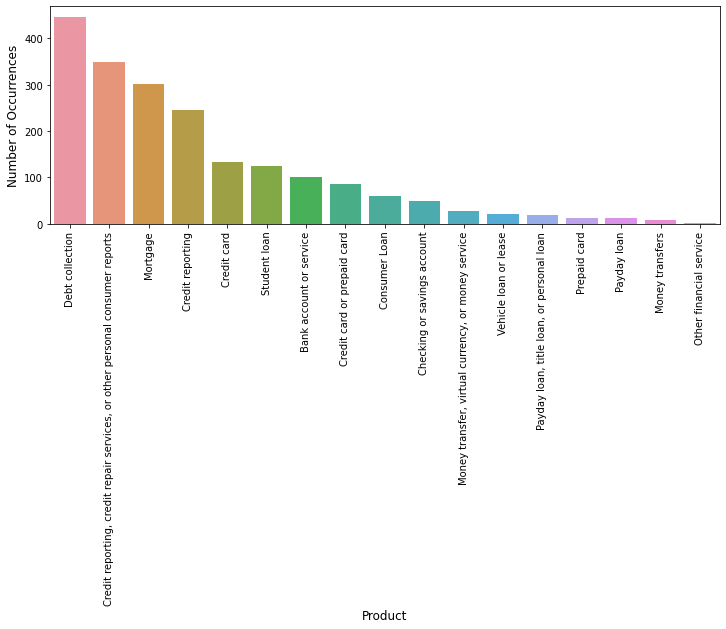

In [134]:
cnt_pro = dff['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(data=dff, x=cnt_pro.index, y=cnt_pro.values)
# sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [135]:
def print_complaint(index):
    example = dff[dff.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])
print_complaint(9)

i recently filed a complaint about us bank. they held the second mortgage to a home i owned, and i tried and tried to get them to modify my loan, but they never even said yes or no at the time. i ended up losing that home. 
us bank sent me something in the mail. they sent me a copy of a note i signed, stating and agreeing that i wold not take the  dollars i could have got from their line of credit. they call this their " loan modification ''. 
what a joke! ... ... .... i have been a realtor for over 20 years, i know a little more than the average person. 
- in reponce, i called us bank up last friday, //. i had to talk to  people in  different departments, i kept getting tossed from one rep to another rep.. etc. 
finally, one rep said.. " oh. im reading here that we kept asking you and asking you for documents, and we never got them ''. so your loan modification was denied ''. 
now i remember what happened. i was completely eligible for a loan mod. the investor was ! i had a true hards

In [136]:
print_complaint(1000)

i went into a local chase branch around  to open an account. i found out there had been an open account under my information that was not mine. i disputed the information with chase and sign all their affidavits etc - they had promised me that once i had fullfilled all there request that i could then open a checking and savings account. finally back in  i got a letter from chase telling me that i was not liable for the account and all the fess and information would be deleted. ( please refer to the second page of the attachment for this information. ) on the second page of the letter they sent me they stated i could open an account again. i went into a branch today //16 to open an account. before the rep even got all of my information she said because there was an open fraud case in the past they would not be able to open a account for me. i eplained to her that it was closed - and i was found not at fault and was promised to open an account once it was all said and done .she said ther

In [137]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
dff['narrative'] = dff['narrative'].apply(cleanText)

/usr/lib/python3/dist-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [138]:
j = 0
for i in text_corpus:
    text_corpus[j] = i[0] +" " + i[1] 
    text_corpus[j] = re.split('; |, |' ' |\n', text_corpus[j])
    j = j + 1


In [139]:
print(text_corpus[1])
print(len(text_corpus))

['i', "'ve", 'disputed', 'an', 'inaccurate', 'bankruptcy', 'with', 'transunion', 'for', 'several', 'months', 'now.', 'transunion', 'consistently', 'responded', 'to', 'the', 'disputed', 'account', 'as', '"', 'verified', "''.", 'they', 'violated', 'several', 'federal', 'rules', 'under', 'the', 'fcra', '623', 'and', '1681i', 'during', 'their', 'so', 'called', 'investigations.', 'transunion', 'has', 'georgia', 'federal', 'court', '-', '', 'listed', 'as', 'the', 'furnisher', 'of', 'information.', 'i', 'received', 'a', 'letter', 'from', 'the', 'courthouse', 'stating', 'that', 'they', 'do', 'not', 'communicate', 'with', 'credit', 'bureaus.', 'transunion', 'did', 'not', 'send', 'a', 'notice', 'of', 'my', 'dispute', 'to', 'the', 'furnisher', 'of', 'information.', 'in', 'fact', 'they', 'are', 'not', 'providing', 'the', 'true', 'furnisher', 'of', 'information', 'for', 'this', 'account', 'as', 'we', 'know', 'the', 'courthouse', 'is', 'not', 'the', 'true', 'furnisher', 'of', 'information.', 'transu

In [140]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim

def tagged_document(lis_of_list_of_words):
    for i, list_of_words in enumerate(lis_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

data_for_training = list(tagged_document(text_corpus))   
print(data_for_training[100])


TaggedDocument<['i', 'received', '', 'fraudulent', 'charges', 'over', 'a', 'two', 'day', 'span', 'that', 'were', 'applied', 'to', 'my', 'checking', 'accounting', 'totaling', 'an', 'amount', 'of', '{$2700.00}.', 'i', 'contacted', 'bank', 'of', 'america', 'on', 'the', 'second', 'day', 'when', 'i', 'noticed', 'the', 'charges', 'and', 'had', 'them', 'closed', 'all', 'the', 'cards', 'associated', 'with', 'the', 'account', 'to', 'stop', 'all', 'activity.', 'i', 'submitted', 'a', 'claim', 'which', 'was', 'processed', 'and', 'returned', 'back', 'to', 'me', 'a', 'week', 'later', 'that', 'advised', 'my', 'claims', 'was', 'rejected', 'due', 'to', 'the', 'charges', 'processing', 'correctly.', 'the', 'evidence', 'regarding', 'said', 'charges', 'clearly', 'demonstrations', 'that', 'all', '{$2700.00}', 'was', 'fraudulently', 'removed', 'from', 'my', 'account.', '', '', 'date', ':', '', '', '2016', '', 'az', '', 'checking', 'account', 'ending', 'in', '', 'claim', 'number', ':', '', 'initiation', 'date

In [141]:
data_for_training[999]

TaggedDocument(words=['i', 'show', 'that', 'all', 'credit', 'reporting', 'companies', 'are', 'putting', 'the', 'credit', 'run', 'by', 'my', 'eisting', 'accounts', 'to', 'verify', 'credit', 'if', 'it', 'get', 'increased', 'or', 'there', 'normal', 'check', 'up', 'shows', 'up', 'like', 'i', 'asked', 'for', 'a', 'new', 'account.', '', 'i', 'have', 'had', 'my', 'loan', 'for', 'home', 'be', 'bought', 'out', '3', 'times', 'now.', 'i', 'show', '', 'on', 'my', 'account', 'now', 'twice', 'that', 'is', 'normal', 'because', 'they', 'purchased', 'the', 'loan', 'that', 'is', 'not', 'me', 'checking', 'for', 'new', 'credit.', 'it', 'was', '', 'now', '', '', 'that', 'has', 'my', 'morgage', '', ':', 'it', 'was', 'run', 'on', '//', 'and', '', '', 'so', 'that', 'is', 'normal', 'for', 'a', 'home', 'lender.', 'please', 'tell', 'them', 'i', 'should', 'not', 'have', 'this', 'against', 'me.', '', '', 'also', 'i', 'have', '', '', '', 'account', 'i', 'have', 'had', 'a', 'long', 'time.', 'they', 'moved', 'over', 

In [142]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=2, epochs=40)
model.build_vocab(data_for_training)

In [143]:
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)
model.save("doc2vec15.model")

In [144]:
# Load pre-trained Word2Vec model.
import gensim
model = gensim.models.Word2Vec.load("doc2vec15.model")

In [145]:
model.dv.most_similar(1999)

[(291, 0.5980145931243896),
 (871, 0.5400157570838928),
 (809, 0.5352950096130371),
 (971, 0.529349684715271),
 (1205, 0.5251392722129822),
 (1410, 0.5234318971633911),
 (533, 0.5040114521980286),
 (1374, 0.5034459829330444),
 (849, 0.49792566895484924),
 (234, 0.4889789819717407)]

In [146]:
vector = model.dv
model.dv[142].shape

(300,)

In [147]:
len(vector)

2000

In [176]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.dv.index_to_key  # list of node IDs
node_embeddings = (
    model.dv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects

In [177]:
# Apply t-SNE transformation on node embeddings
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

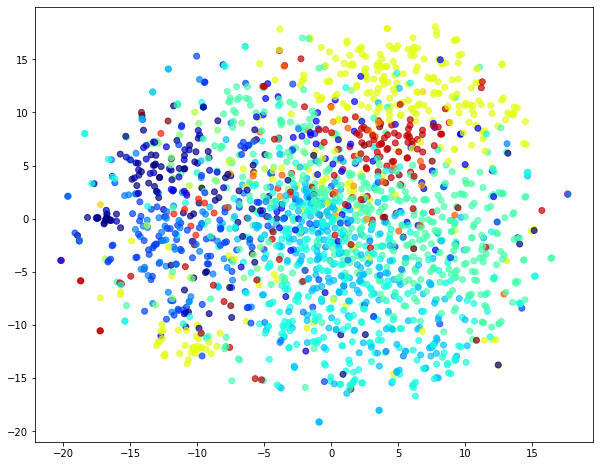

In [178]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

In [179]:
X = node_embeddings
X[1:100]


array([[-0.32971087,  0.21997152, -0.13552259, ...,  0.36139706,
         0.550821  , -0.69974476],
       [-0.17871004,  0.44400093, -0.00818687, ..., -0.12780748,
         0.3794235 , -0.55968356],
       [ 0.1733822 ,  0.51086223,  0.18062742, ..., -0.38561624,
         0.5734198 , -0.14428587],
       ...,
       [-0.01787616,  0.35468757, -0.15994512, ..., -0.28474203,
         0.25830832, -0.27273664],
       [-0.17591915,  0.32809672, -0.05437399, ..., -0.06107667,
         0.33864743, -0.40688792],
       [ 0.7969342 ,  2.3653166 ,  1.0916288 , ...,  1.143226  ,
         0.6027133 , -1.2259427 ]], dtype=float32)

In [180]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)




# setting distance_threshold=0 ensures we compute the full tree.
modelCluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

modelCluster = modelCluster.fit(X)


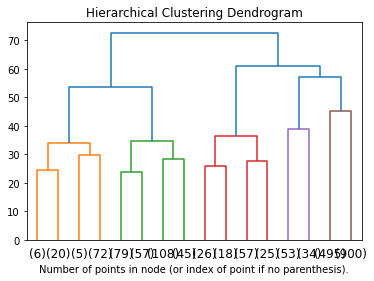

In [181]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(modelCluster, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [204]:
# setting distance_threshold=0 ensures we compute the full tree.
modelCluster = AgglomerativeClustering(distance_threshold=25, n_clusters=None)

model1 = modelCluster.fit(X)

In [205]:
labels = model1.labels_.tolist()
nocluster = set(labels)
totalcluster = len(nocluster)
totalcluster

22

In [206]:
cluster_dict = {}

i = 0
for i in range(len(labels)):
    if labels[i] not in cluster_dict.keys():
         cluster_dict[labels[i]] = [i]
    else:
          cluster_dict[labels[i]].append(i)
    i+=1

In [207]:
vb = []
X[cluster_dict[0]]
cluster_dict[0]
X[[5, 88, 22]]

array([[-2.78859794e-01,  3.79462004e-01, -9.18238908e-02,
        -7.30034262e-02, -6.46415427e-02, -6.09248519e-01,
         7.65162483e-02,  6.92516625e-01,  1.33168817e-01,
        -2.85445690e-01,  4.64306548e-02, -2.22254962e-01,
        -2.41464376e-01,  2.74762511e-01,  3.38707268e-01,
        -3.64509523e-02,  1.92525629e-02,  2.62135267e-02,
         6.92578852e-02, -1.36368349e-01,  2.36806870e-01,
         7.69747347e-02,  2.01799586e-01,  1.34533182e-01,
        -5.29453695e-01, -1.32768244e-01, -3.18651944e-01,
        -3.27925868e-02, -2.43056163e-01, -1.54905617e-01,
        -1.84380158e-03, -3.54488283e-01,  1.56820238e-01,
         1.25832319e-01,  4.65355106e-02,  2.15538979e-01,
         2.81843573e-01, -3.93987894e-01,  2.39707425e-01,
         6.25173301e-02, -1.83594748e-01, -5.92795312e-02,
        -9.38192606e-02, -1.28640935e-01,  6.32171556e-02,
         8.11287835e-02, -1.23931505e-01,  3.26672979e-02,
         1.58751711e-01,  9.00333077e-02,  2.13886350e-0

In [208]:
for i in range(totalcluster):
    print(len(cluster_dict[i]))

33
242
26
53
118
72
90
32
244
18
136
2
47
1
403
5
251
108
13
57
26
23


In [209]:
outlier_cluster_list = []
for i in range(totalcluster):
    if len(cluster_dict[i]) <= 5:
        outlier_cluster_list.append(i)
    
print(outlier_cluster_list)

[11, 13, 15]


In [210]:
# X[cluster_dict[outlier_cluster_list[0]]]

In [211]:
cluster_dict[outlier_cluster_list[0]]


[1289, 1853]

In [212]:
# X[779]

In [213]:
cluster_mean = np.zeros((totalcluster, vector[1].size))

for i in range(totalcluster):
    cluster_mean[i] = np.mean(X[cluster_dict[i]], axis=0)
    


In [214]:
cluster_mean[2]
X[cluster_dict[28][1]]

KeyError: 28

In [221]:
# from scipy.spatial import distance
# cluster_distance = []
# for i in range(totalcluster):
#     if i == outlier_cluster[0]:
#         continue
#     cluster_distance.append((distance.euclidean(cluster_mean[outlier_cluster[0]], cluster_mean[i]),outlier_cluster[0], i))

# print('Distance,    outlier, other-cluster')
# cluster_distance


# outlier need to change here for differnet experiment

from scipy.spatial import distance
outlier_cluster = outlier_cluster_list[2]
cluster_distance = []
for i in range(totalcluster):
    if i == outlier_cluster:
        continue
    cluster_distance.append((distance.euclidean(cluster_mean[outlier_cluster], cluster_mean[i]),outlier_cluster, i))
print('Euclidian distancce, Outlire, Other cluster')
cluster_distance

Euclidian distancce, Outlire, Other cluster


[(10.498886368401111, 15, 0),
 (13.180546454404022, 15, 1),
 (11.818010270337476, 15, 2),
 (12.79314121045672, 15, 3),
 (12.673677050908871, 15, 4),
 (9.739436934252653, 15, 5),
 (12.33966681027153, 15, 6),
 (12.87075820707928, 15, 7),
 (12.804025775665306, 15, 8),
 (13.426626177204518, 15, 9),
 (11.522112143069844, 15, 10),
 (20.656924136187122, 15, 11),
 (12.902098025027017, 15, 12),
 (24.568529197543917, 15, 13),
 (12.627804350093731, 15, 14),
 (12.86332615172442, 15, 16),
 (12.267611250842677, 15, 17),
 (12.339788353304495, 15, 18),
 (14.08537033827128, 15, 19),
 (13.43457933297524, 15, 20),
 (14.284341560585085, 15, 21)]

In [222]:
cluster_distance.sort(key=lambda y: y[0])
cluster_distance = cluster_distance[:5]
cluster_distance

[(9.739436934252653, 15, 5),
 (10.498886368401111, 15, 0),
 (11.522112143069844, 15, 10),
 (11.818010270337476, 15, 2),
 (12.267611250842677, 15, 17)]

In [223]:
k_nearest_cluster = list(zip(*cluster_distance[:5]))[2]
k_nearest_cluster

(5, 0, 10, 2, 17)

In [226]:
  def findCandidateClusters(k_nearest_cluster):
    closestCluster = k_nearest_cluster[0][2]
    closestDistance = k_nearest_cluster[0][0]
    candidateCluster = []
    rejectedCluster = []
    dist = distance.euclidean(cluster_mean[closestCluster],cluster_mean[k_nearest_cluster[0][1]])
#     print(dist)
    candidateCluster.append(k_nearest_cluster[0])
    for i in k_nearest_cluster:
        if i in rejectedCluster:
            print('rejected')
            print(rejectedCluster)
            continue
        for j in k_nearest_cluster:
            if j == i: continue
            dist_btwn = distance.euclidean(cluster_mean[i[2]],cluster_mean[j[2]])
            origin = cluster_mean[i[2]] + (- cluster_mean[i[2]])
            translate_outlier = cluster_mean[i[1]] + (- cluster_mean[i[2]])
            translate_cluster = cluster_mean[j[2]] + (- cluster_mean[i[2]])
            cos_dist = distance.cosine(translate_outlier, translate_cluster)
            print(dist_btwn)
            print(cos_dist)
            print(j)
            print('')
            if cos_dist < 1  :
                if j in candidateCluster:
                    continue
                candidateCluster.append(j)
            else:
                if j not in rejectedCluster:
                    rejectedCluster.append(j)
                if j in candidateCluster:
                    print(j)
                    print('is included') 
                    candidateCluster.remove(j)   
                    
        for i in candidateCluster:
            if i in rejectedCluster:
                candidateCluster.remove(i)

    return  candidateCluster   

In [227]:
neighborCluster = findCandidateClusters(cluster_distance)
neighborCluster

5.388196226964058
0.8698247256755688
(10.498886368401111, 15, 0)

3.636570486383168
1.348377770985426
(11.522112143069844, 15, 10)

5.307366449495089
1.1609629657188651
(11.818010270337476, 15, 2)

4.828257072667529
1.3437100238048305
(12.267611250842677, 15, 17)

5.388196226964058
0.6075429138195618
(9.739436934252653, 15, 5)

4.84272363055886
0.9909573078733894
(11.522112143069844, 15, 10)

7.321317401654942
0.8428236314950276
(11.818010270337476, 15, 2)

5.599696180843191
1.0757865837691425
(12.267611250842677, 15, 17)

rejected
[(11.522112143069844, 15, 10), (11.818010270337476, 15, 2), (12.267611250842677, 15, 17)]
rejected
[(11.522112143069844, 15, 10), (11.818010270337476, 15, 2), (12.267611250842677, 15, 17)]
rejected
[(11.522112143069844, 15, 10), (11.818010270337476, 15, 2), (12.267611250842677, 15, 17)]


[(9.739436934252653, 15, 5),
 (10.498886368401111, 15, 0),
 (11.818010270337476, 15, 2)]

In [228]:
dff.loc[cluster_dict[1][2]]

narrative    , , fl big picture loans took out this loan fo...
Product                                          Consumer Loan
Name: 55, dtype: object

In [233]:
print_complaint(cluster_dict[2][1])

in   my husband and i drove past a sweet brick ranch home with a for sale sign in front. we called our realtor and asked him to show it to us. he did and we began to write offers. the  offered in  was chosen and we signed a contract over  and it was returned signed on  ,  with the understanding that my husband and i were going to be using a   (  ) loan. the seller was listed as  in . the home is here in  , . our first closing date was the end of  . as of  ,  we still had not closed, 9 months later!!!!! the listing agent could only communicate with the bank 's rep/responsible person by email and fa. we submitted a cfpa complaint in in  over the fact that the home needed to be hooked up to city sewer ( which our realtor discovered ) which had never been disclosed to us. it was sent first to  in  and then a man there forwarded it to wells fargo. ( who or what owns the property? ) finally after waiting and waiting, the sewer was hooked up in  day and the yard was left in a total mess with 

In [114]:
def findNearestObjectOfClusters(k_nearest_cluster):
    distance_all_cluster = []
    nearestObjects = []
    object_distance = []
    for j in range(len(k_nearest_cluster)):
        for i in range(len(cluster_dict[k_nearest_cluster[j]])):
            object_distance.append((distance.euclidean(cluster_mean[outlier_cluster[0]], X[cluster_dict[k_nearest_cluster[j]][i]]),outlier_cluster[0], k_nearest_cluster[j],  cluster_dict[k_nearest_cluster[j]][i]))
        #distance_all_cluster.append(object_distance)
        nearestObjects.append(min(object_distance, key=lambda tup: tup[0]))
        object_distance = []
    return  nearestObjects   

In [94]:
nearestObjects = findNearestObjectOfClusters(k_nearest_cluster)
nearestObjects.sort(key=lambda y: y[0])
nearestObjects

[(6.211557735200479, 57, 17, 8416),
 (6.4437189412621585, 57, 39, 2981),
 (6.595669598420173, 57, 28, 1136),
 (6.704557161093288, 57, 59, 612),
 (7.672551043958055, 57, 40, 4299)]

In [45]:
from scipy.spatial import distance
distance.cosine(X[1], X[28])

0.7182227075099945

In [95]:
def findCandidateObjectOfClusters(k_nearest_objects):
    closestObject = k_nearest_objects[0][3]
    closestDistance = k_nearest_objects[1][0]
    candidateObjects = []
    candidateObjects.append(k_nearest_objects[0])
    for j in range(len(k_nearest_objects)):
        #if j == 0: continue
        dist = distance.euclidean(X[closestObject], X[k_nearest_objects[j][3]])
        cos_dist = distance.cosine(X[closestObject], X[k_nearest_objects[j][3]])
        print(dist)
        if cos_dist >= 1 and dist  >=  closestDistance :
            candidateObjects.append(k_nearest_objects[j])
    return  candidateObjects   

In [98]:
neighborObjects = findCandidateObjectOfClusters(nearestObjects)
neighborObjects

0.0
5.153873443603516
5.172466278076172
7.54621696472168
7.085255146026611


[(6.211557735200479, 57, 17, 8416)]

In [48]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=10, centers=3, n_features=2,random_state=0)